# ***Import Libraries***

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import os
import cv2
from PIL import Image
import random
import shutil
import warnings
warnings.filterwarnings('ignore')

# ***Load Data***

In [2]:
from google.colab import files
uploaded = files.upload()  # Click and upload `potato_disease.zip`


Saving plantvillage.zip to plantvillage.zip


In [3]:
import zipfile
import os

zip_path = "/content/plantvillage.zip"  # Change if your zip has a different name
extract_path = "potato_disease"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# ***Data Configuration***

In [11]:
# Dataset Configuration
DATASET_PATH = '/content/potato_disease/plantvillage'  # Update this path
CLASS_NAMES = ["Potato___Early_blight", "Potato___Late_blight", "Potato___healthy"]
NUM_CLASSES = len(CLASS_NAMES)

In [12]:
print(CLASS_NAMES)

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [13]:
# Image parameters
IMG_HEIGHT = 256
IMG_WIDTH = 256
CHANNELS = 3
BATCH_SIZE = 32
EPOCHS = 26

# ***showing Data set Image***

In [14]:
# Count images per class
print("📊 TOTAL IMAGES PER CLASS")
print("=" * 30)
for class_name in sorted(CLASS_NAMES):
    class_path = os.path.join(DATASET_PATH, class_name)
    image_count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    clean_name = class_name.replace("Potato___", "").replace("_", " ").title()
    print(f"{clean_name}: {image_count} images")

📊 TOTAL IMAGES PER CLASS
Early Blight: 1000 images
Late Blight: 1000 images
Healthy: 152 images


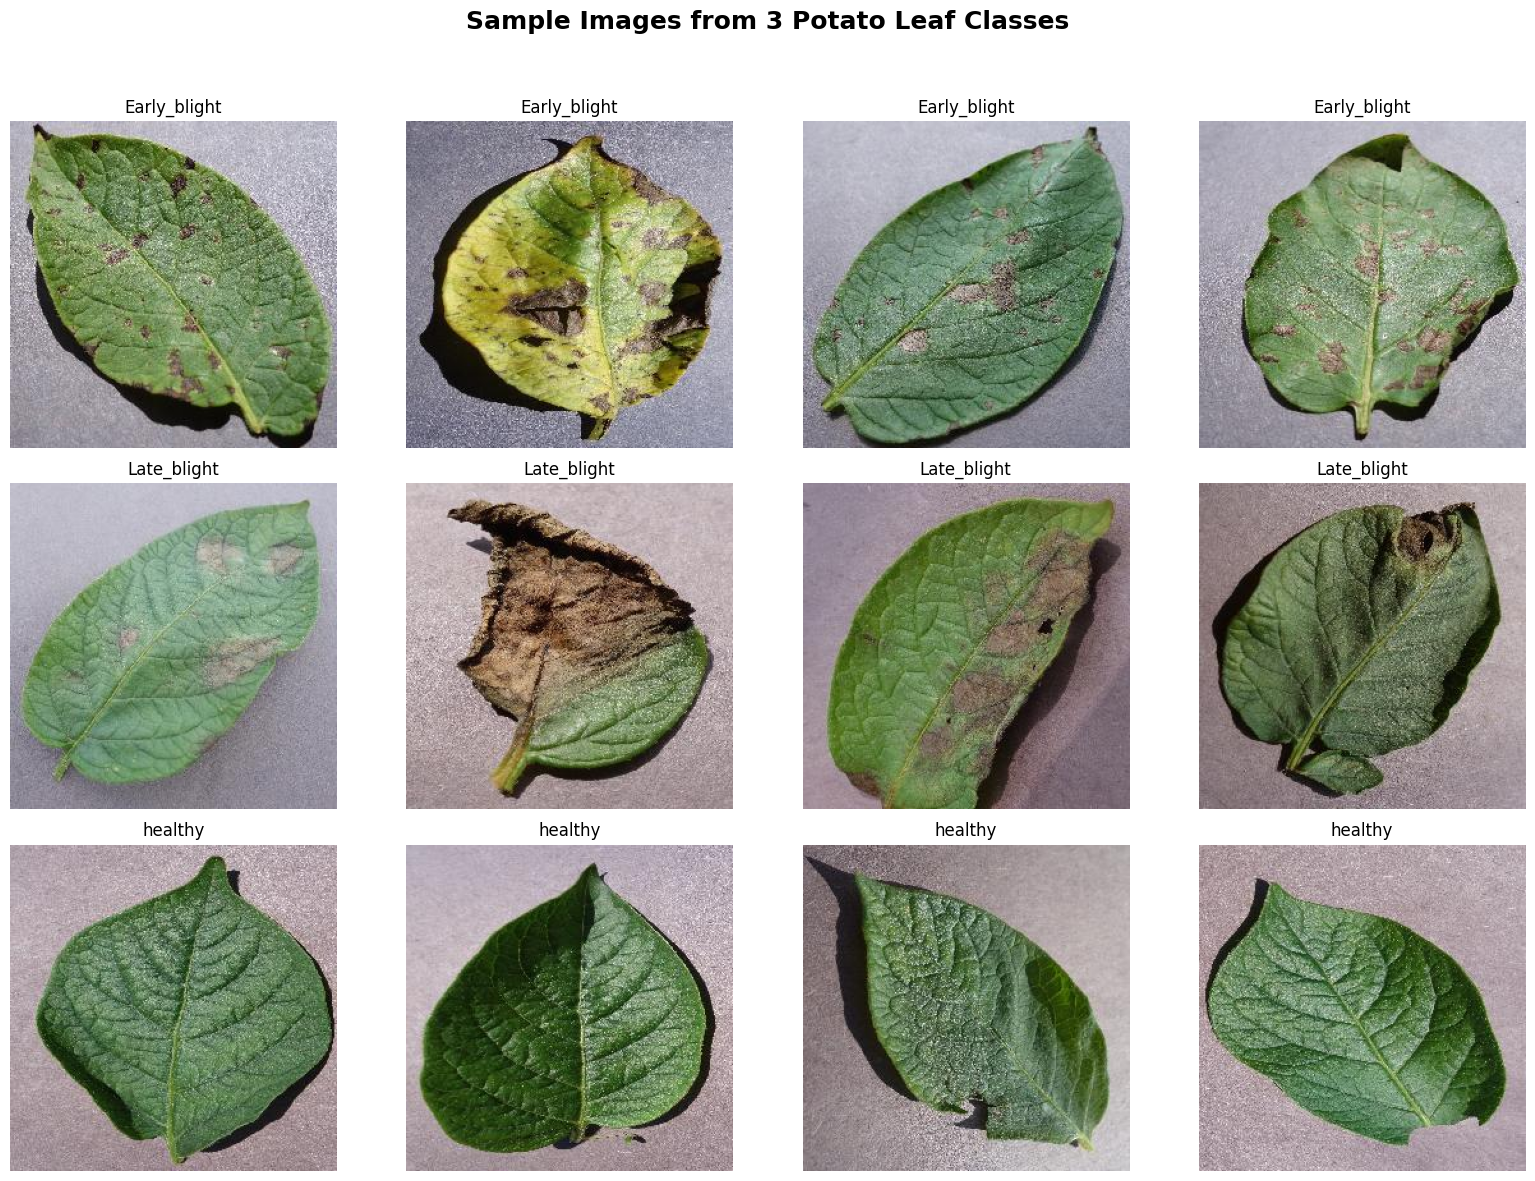

In [15]:
# Setup the figure
plt.figure(figsize=(16, 12))
image_count = 0
total_classes = len(CLASS_NAMES)
images_per_class = 4 # Define images_per_class

for class_index, class_name in enumerate(CLASS_NAMES):
    class_dir = os.path.join(DATASET_PATH, class_name)

    if os.path.isdir(class_dir):
        image_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        random.shuffle(image_files)
        selected_images = image_files[:images_per_class]

        for i, image_file in enumerate(selected_images):
            img_path = os.path.join(class_dir, image_file)
            try:
                img = Image.open(img_path)
                ax = plt.subplot(total_classes, images_per_class, image_count + 1)
                plt.imshow(img)
                plt.title(class_name.replace("Potato___", ""))
                plt.axis("off")
                image_count += 1
            except Exception as e:
                print(f"❌ Could not load image {img_path}: {e}")

plt.suptitle("Sample Images from 3 Potato Leaf Classes", fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# ***Split Data into Train/Val/Test ***

In [16]:
pip install split-folders

In [17]:
# Constants
SOURCE_PATH = '/content/potato_disease/plantvillage'
DEST_PATH = '/content/split_dataset'
CLASS_NAMES = ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
TRAIN_SPLIT, VAL_SPLIT, TEST_SPLIT = 0.7, 0.2, 0.1

print("Using Full Train/Validation/Test Split (70/20/10)")
print("=" * 50)
print(f"Creating organized dataset structure at: {DEST_PATH}")
print("\nCreating Train/Validation/Test Split...")
print("=" * 50)

for class_name in CLASS_NAMES:
    source_class_path = os.path.join(SOURCE_PATH, class_name)

    # Create output directories
    for split in ['train', 'val', 'test']:
        os.makedirs(os.path.join(DEST_PATH, split, class_name), exist_ok=True)

    # Collect and shuffle images
    all_images = [f for f in os.listdir(source_class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    random.shuffle(all_images)

    total = len(all_images)
    train_end = int(TRAIN_SPLIT * total)
    val_end = train_end + int(VAL_SPLIT * total)

    train_files = all_images[:train_end]
    val_files = all_images[train_end:val_end]
    test_files = all_images[val_end:]

    # Copy images
    for file in train_files:
        shutil.copy(os.path.join(source_class_path, file), os.path.join(DEST_PATH, 'train', class_name, file))
    for file in val_files:
        shutil.copy(os.path.join(source_class_path, file), os.path.join(DEST_PATH, 'val', class_name, file))
    for file in test_files:
        shutil.copy(os.path.join(source_class_path, file), os.path.join(DEST_PATH, 'test', class_name, file))

    # Print summary
    print(f"{class_name}:")
    print(f"  Train: {len(train_files)} ({(len(train_files)/total)*100:.1f}%)")
    print(f"  Val:   {len(val_files)} ({(len(val_files)/total)*100:.1f}%)")
    print(f"  Test:  {len(test_files)} ({(len(test_files)/total)*100:.1f}%)")
    print(f"  Total: {total}\n")

print("✅ Dataset successfully split into train/validation/test sets!")


Using Full Train/Validation/Test Split (70/20/10)
Creating organized dataset structure at: /content/split_dataset

Creating Train/Validation/Test Split...
Potato___Early_blight:
  Train: 700 (70.0%)
  Val:   200 (20.0%)
  Test:  100 (10.0%)
  Total: 1000

Potato___Late_blight:
  Train: 700 (70.0%)
  Val:   200 (20.0%)
  Test:  100 (10.0%)
  Total: 1000

Potato___healthy:
  Train: 106 (69.7%)
  Val:   30 (19.7%)
  Test:  16 (10.5%)
  Total: 152

✅ Dataset successfully split into train/validation/test sets!


In [18]:
import splitfolders

splitfolders.ratio(DATASET_PATH, output="dataset", seed=1337, ratio=(TRAIN_SPLIT, VAL_SPLIT, TEST_SPLIT))

Copying files: 2152 files [00:00, 4843.75 files/s]


In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = 256  # for convenience

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=10, horizontal_flip=True)
validation_datagen = ImageDataGenerator(rescale=1./255, rotation_range=10, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'dataset/train',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="sparse"
)

validation_generator = validation_datagen.flow_from_directory(
    'dataset/val',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="sparse"
)

test_generator = test_datagen.flow_from_directory(
    'dataset/test',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="sparse"
)

class_names = list(train_generator.class_indices.keys())


Found 1506 images belonging to 3 classes.
Found 430 images belonging to 3 classes.
Found 216 images belonging to 3 classes.


# ***Visualize Data Split Distribution***

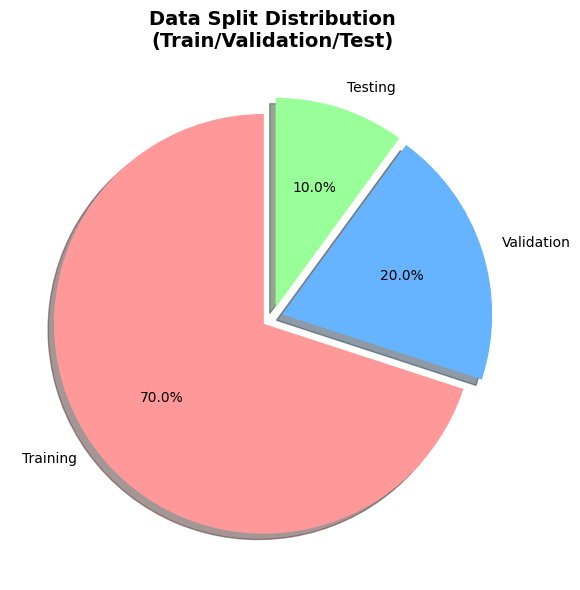

📊 DETAILED DATA SPLIT BREAKDOWN:
🏋️  Training:   1,506 images (70.0%)
🔍 Validation: 430 images (20.0%)
🧪 Testing:    216 images (10.0%)
📈 Total:      2,152 images (100.0%)

📋 CLASS-WISE DISTRIBUTION:
Early Blight:
  🏋️  Train: 700 | 🔍 Val: 200 | 🧪 Test: 100
Late Blight:
  🏋️  Train: 700 | 🔍 Val: 200 | 🧪 Test: 100
Healthy:
  🏋️  Train: 106 | 🔍 Val: 30 | 🧪 Test: 16



In [23]:
import os
import shutil
import random
from math import floor

# Original dataset path
ORIGINAL_DATASET_DIR = "/content/potato_disease/plantvillage"
SPLIT_DATASET_DIR = "/content/split_dataset"

# Define splits
TRAIN_SPLIT = 0.7
VAL_SPLIT = 0.2
TEST_SPLIT = 0.1

# Classes
CLASS_NAMES = ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

def split_dataset(source_dir, dest_dir, train_split, val_split, test_split, class_names):
    if os.path.exists(dest_dir):
        shutil.rmtree(dest_dir)
    os.makedirs(dest_dir)

    for split in ['train', 'val', 'test']:
        for class_name in class_names:
            os.makedirs(os.path.join(dest_dir, split, class_name), exist_ok=True)

    for class_name in class_names:
        class_dir = os.path.join(source_dir, class_name)
        images = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        random.shuffle(images)

        total_images = len(images)
        train_count = floor(train_split * total_images)
        val_count = floor(val_split * total_images)
        test_count = total_images - train_count - val_count

        # Copy images
        for i, img_name in enumerate(images):
            src = os.path.join(class_dir, img_name)
            if i < train_count:
                dst = os.path.join(dest_dir, 'train', class_name, img_name)
            elif i < train_count + val_count:
                dst = os.path.join(dest_dir, 'val', class_name, img_name)
            else:
                dst = os.path.join(dest_dir, 'test', class_name, img_name)
            shutil.copy2(src, dst)

# Run splitting
split_dataset(ORIGINAL_DATASET_DIR, SPLIT_DATASET_DIR, TRAIN_SPLIT, VAL_SPLIT, TEST_SPLIT, CLASS_NAMES)
visualize_data_split_from_dirs(SPLIT_DATASET_DIR, CLASS_NAMES)



# ***Building the Model***

In [25]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = NUM_CLASSES

model = Sequential([
    layers.InputLayer(input_shape=input_shape),
    layers.Conv2D(32, (3, 3), activation='relu'), layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'), layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'), layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'), layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'), layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'), layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])


In [26]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [27]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

# ***Train the Model***

In [28]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=EPOCHS,
    verbose=1,
)


Epoch 1/26
48/48 ━━━━━━━━━━━━━━━━━━━━ 43s 713ms/step - accuracy: 0.4830 - loss: 0.9751 - val_accuracy: 0.5442 - val_loss: 0.8060
Epoch 2/26
48/48 ━━━━━━━━━━━━━━━━━━━━ 31s 649ms/step - accuracy: 0.6562 - loss: 0.7014 - val_accuracy: 0.7279 - val_loss: 0.6123
Epoch 3/26
48/48 ━━━━━━━━━━━━━━━━━━━━ 40s 633ms/step - accuracy: 0.7593 - loss: 0.5385 - val_accuracy: 0.9047 - val_loss: 0.2263
Epoch 4/26
48/48 ━━━━━━━━━━━━━━━━━━━━ 27s 563ms/step - accuracy: 0.9194 - loss: 0.2046 - val_accuracy: 0.9163 - val_loss: 0.2007
Epoch 5/26
48/48 ━━━━━━━━━━━━━━━━━━━━ 27s 565ms/step - accuracy: 0.9388 - loss: 0.1706 - val_accuracy: 0.9558 - val_loss: 0.1251
Epoch 6/26
48/48 ━━━━━━━━━━━━━━━━━━━━ 42s 577ms/step - accuracy: 0.9601 - loss: 0.1132 - val_accuracy: 0.9442 - val_loss: 0.1346
Epoch 7/26
48/48 ━━━━━━━━━━━━━━━━━━━━ 40s 562ms/step - accuracy: 0.9594 - loss: 0.1016 - val_accuracy: 0.9814 - val_loss: 0.0505
Epoch 8/26
48/48 ━━━━━━━━━━━━━━━━━━━━ 27s 559ms/step - accuracy: 0.9690 - loss: 0.0819 - val_accu

# ***Model Evaluation***

In [29]:
scores = model.evaluate(test_generator)
print("Test Accuracy:", scores[1])


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 284ms/step - accuracy: 0.9883 - loss: 0.0240
Test Accuracy: 0.9907407164573669


# ***Plot Training History***

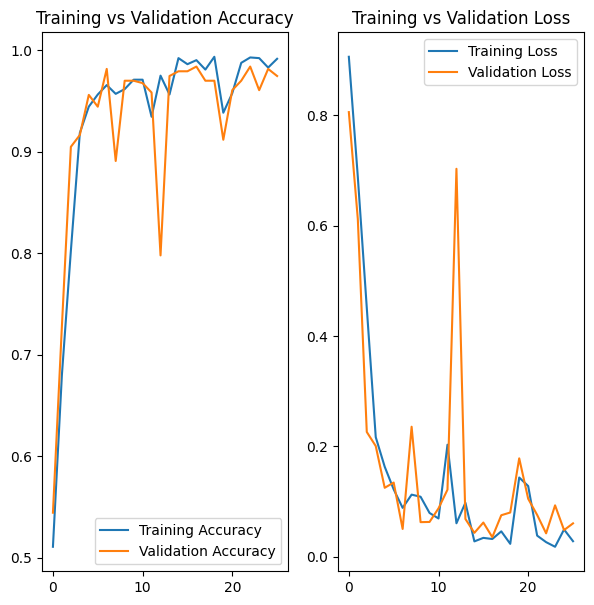

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(7, 7))

plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend()
plt.title('Training vs Validation Loss')

plt.show()



# ***VALIDATION SET EVALUATION***

In [32]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Get ground truth labels and predictions from the validation generator
y_true = []
y_pred = []

# Reset generator to avoid incomplete batch issues
validation_generator.reset()

for i in range(len(validation_generator)):
    x_batch, y_batch = validation_generator[i]
    preds = model.predict(x_batch)
    preds_class = np.argmax(preds, axis=1)

    y_true.extend(y_batch)
    y_pred.extend(preds_class)

y_true = np.array(y_true, dtype=np.int32)
y_pred = np.array(y_pred, dtype=np.int32)

# Evaluation Metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Display results
print("\nVALIDATION SET EVALUATION:")
print("=" * 50)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

print("\nDetailed Classification Report:")
print("=" * 40)

# Get class label names
target_names = class_names  # e.g., ["Potato___Early_blight", ...]

# Optional: Clean class names for display
target_names = [name.split("___")[-1].replace("_", " ") for name in target_names]

print(classification_report(y_true, y_pred, target_names=target_names))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step

VALIDATION SET EVALUATION:
Accuracy:  0.9698
Precision: 0.9716
Recall:    0.9698
F1-Score:  0.9698

Detailed Classification Report:
              precision    recall  f1-score   support

Early blight       1.00      0.94      0.97       200
 Late blight       0.94      1.00      0.97       200
     healthy       1.00      0.93      0.97        30

    accuracy                           0.97       430
   macro avg       0.98      0.96      0.97       430
weighted

# ***PERFORMANCE COMPARISON***

In [31]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import pandas as pd

def evaluate_model(generator, set_name="Validation"):
    y_true, y_pred = [], []

    generator.reset()

    for i in range(len(generator)):
        x_batch, y_batch = generator[i]
        preds = model.predict(x_batch)
        preds_class = np.argmax(preds, axis=1)

        y_true.extend(y_batch)
        y_pred.extend(preds_class)

    y_true = np.array(y_true, dtype=np.int32)
    y_pred = np.array(y_pred, dtype=np.int32)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    # Display header
    print(f"\n{set_name.upper()} SET EVALUATION:")
    print("=" * 50)
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")

    # Detailed Report
    print(f"\nDetailed Classification Report:")
    print("=" * 40)
    target_names = [name.split("___")[-1].replace("_", " ") for name in class_names]
    print(classification_report(y_true, y_pred, target_names=target_names, zero_division=0))

    return accuracy, precision, recall, f1


# Ensure generators don't shuffle data
train_generator.shuffle = False
test_generator.shuffle = False

# Run evaluations
train_metrics = evaluate_model(train_generator, "Training")
test_metrics = evaluate_model(test_generator, "Test")

# Performance Comparison Table
print("\nPERFORMANCE COMPARISON:")
print("=" * 40)

metrics_labels = ["Accuracy", "Precision", "Recall", "F1-Score"]
print(f"{'Metric':<12} {'Training':<12} {'Test':<12} {'Difference':<12}")
print("-" * 48)

for label, train_val, test_val in zip(metrics_labels, train_metrics, test_metrics):
    diff = round(abs(test_val - train_val), 4)
    print(f"{label:<12} {train_val:<12.4f} {test_val:<12.4f} {diff:<12.4f}")

# Warning if test >> train (possible overfitting or leakage)
if test_metrics[0] - train_metrics[0] > 0.3:
    print("\n⚠ WARNING: Test accuracy is significantly higher than training accuracy!")
    print(" This is unusual and might indicate:")
    print(" - Data leakage between train and test sets")
    print(" - Issues with data splitting")
    print(" - Very small dataset size")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━

# ***show_predictions_with_Image***

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


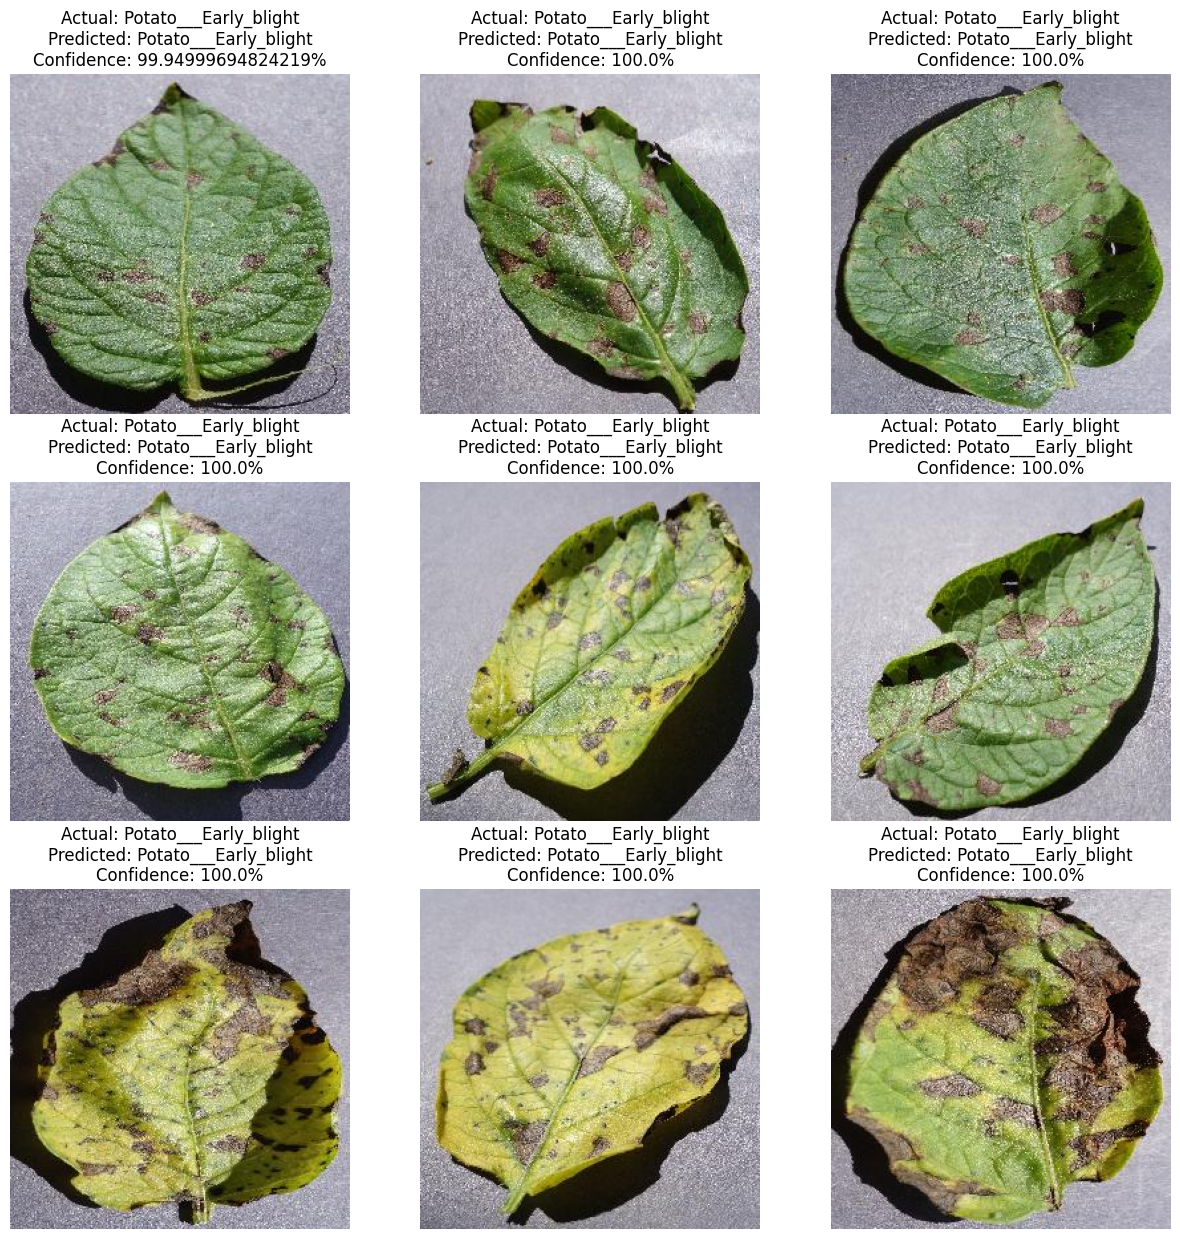

In [33]:
import numpy as np

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)
    return predicted_class, confidence

# Show 9 test predictions
plt.figure(figsize=(15, 15))
for images, labels in test_generator:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[int(labels[i])]
        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%")
        plt.axis("off")
    break


# ***save model***

In [34]:
# Save the trained model
model.save('potato_disease_Model_Model_Model.h5')


# ***Download Files from Colab***

In [35]:
from google.colab import files

In [36]:
# Download the model files
files.download('potato_disease_Model_Model_Model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>